In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import holoviews as hv
import panel as pn
pn.extension()
import hvplot.pandas  # noqa
# podemos adicionar o comentário '# noqa' no fim da linha (como acima) para informar 
# ao linter para ignorar esse erro específico para essa linha.

%matplotlib inline
from bokeh.io import show

In [2]:
index = pd.date_range('2021-01-01', periods=1000)
df = pd.DataFrame(np.random.randn(1000, 4), index=index, columns=list('ABCD')).cumsum()

# df.head()

In [3]:
pd.options.plotting.backend = 'holoviews'
hvplot.extension('bokeh')

O import hvplot.pandas adicionou dinamicamente o método Pandas .hvplot(), para que possamos usar a mesma sintaxe da plotagem padrão do Pandas. 

In [4]:
df.plot()

:NdOverlay   [Variable]
   :Curve   [index]   (value)

In [5]:
df.hvplot()

:NdOverlay   [Variable]
   :Curve   [index]   (value)

Se preferir ser mais explícito, você pode trabalhar diretamente com objetos hvPlot:

In [6]:
from hvplot import hvPlot
hvplot.extension('matplotlib') # selecionando outro backend

:NdOverlay   [Variable]
   :Curve   [index]   (value)
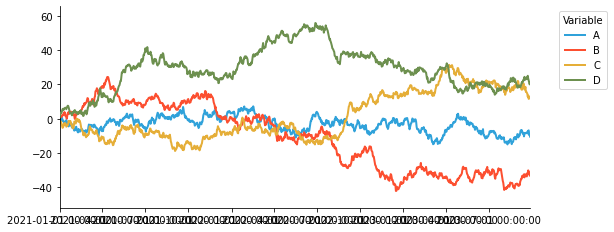

In [7]:
plot = hvPlot(df)
plot(y=['A', 'B', 'C', 'D'])

In [8]:
# Cria outro DataFrame de exemplo
df = pd.DataFrame({'x': [1, 2, 3], 'y': [4, 5, 6]})

In [9]:
# Salvando o gráfico usando backends diferentes
# Using bokeh
hvplot.output(backend='bokeh') # Use para mudar o backend
plot = df.hvplot.line(x='x', y='y')
hv.save(plot, 'plot.html') # O método save também aceita o parâmetro: backend='bokeh'

In [10]:
plot

:Curve   [x]   (y)

In [11]:
# Salvando o gráfico usando backends diferentes
# Using matplotlib
hvplot.output(backend='matplotlib') # Use para mudar o backend
plot = df.hvplot.line(x='x', y='y')
hv.save(plot, 'plot.png')

:Curve   [x]   (y)
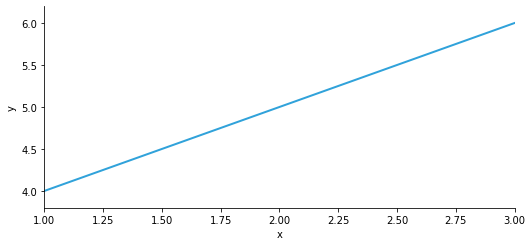

In [12]:
plot

In [13]:
# Using bokeh
bokeh_fig = hv.render(plot, backend='bokeh')

In [14]:
type(bokeh_fig)

bokeh.plotting._figure.figure

In [15]:
show(bokeh_fig)

In [16]:
# Using matplotlib
plt_fig = hv.render(plot, backend='matplotlib')

In [17]:
type(plt_fig)

matplotlib.figure.Figure

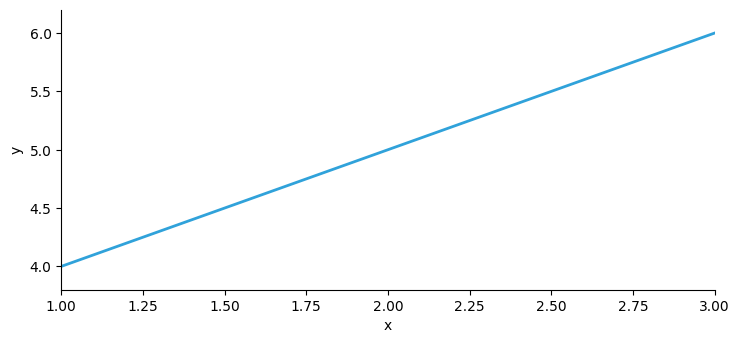

In [18]:
from IPython.display import display
display(plt_fig)

Outro exemplo

In [19]:
df = pd.DataFrame(
    {
        "actual": [100, 150, 125, 140, 145, 135, 123],
        "forecast": [90, 160, 125, 150, 141, 141, 120],
        "numerical": [1.1, 1.9, 3.2, 3.8, 4.3, 5.0, 5.5],
        "date": pd.date_range("2022-01-03", "2022-01-09"),
        "string": ["Mon", "Tue", "Wed", "Thu", "Fri", "Sat", "Sun"],
    },
)
my_graph = df.hvplot.line(
    x="numerical",
    y=["actual", "forecast"],
    ylabel="value",
    legend="bottom",
    height=500,
    # color=["steelblue", "teal"],
    # alpha=0.7,
    linewidth=2,
)

:NdOverlay   [Variable]
   :Curve   [numerical]   (value)
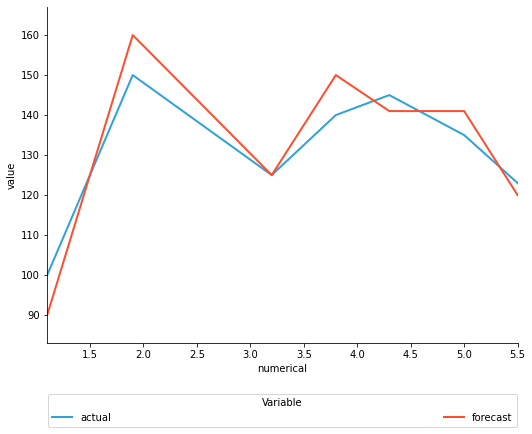

In [20]:
my_graph

Usando Interatividade nos gráficos

In [21]:
df.interactive(width=600).head(n=pn.widgets.IntSlider(start=1, end=7, value=3))

In [22]:
# Configurando o backend para usar 'bokeh'
hvplot.output(backend='bokeh')
from bokeh.sampledata import stocks
from hvplot.interactive import Interactive
ticker = pn.widgets.Select(options=['AAPL', 'IBM', 'GOOG', 'MSFT'], name='Ticker')

def stock_df(ticker):
    df = pd.DataFrame(getattr(stocks, ticker))
    df['date'] = pd.to_datetime(df.date)
    return df

stock_dfi: Interactive = hvplot.bind(stock_df, ticker).interactive(width=600)

In [23]:
stock_dfi.head(5)

In [24]:
# Obtém o DataFrame correspondente ao ticker selecionado
selected_ticker = ticker.value
df_selected_ticker = stock_df(selected_ticker)

In [25]:
df_selected_ticker


,date,open,high,low,close,volume,adj_close
0,2000-03-01,118.56,132.06,118.50,130.31,38478000,31.68
1,2000-03-02,127.00,127.94,120.69,122.00,11136800,29.66
2,2000-03-03,124.87,128.23,120.00,128.00,11565200,31.12
3,2000-03-06,126.00,129.13,125.00,125.69,7520000,30.56
4,2000-03-07,126.44,127.44,121.12,122.87,9767600,29.87
...,...,...,...,...,...,...,...
3265,2013-02-25,453.85,455.12,442.57,442.80,13306400,437.00
3266,2013-02-26,443.82,451.54,437.66,448.97,17910700,443.09
3267,2013-02-27,448.43,452.44,440.65,444.57,20976800,438.75
3268,2013-02-28,444.05,447.87,441.40,441.40,11518400,435.62


Como você pode ver, este componente interativo se comporta como qualquer outro, permitindo-nos encadear 
`.head` nele e atualizá-lo quando o _widget_ de **Ticker** muda.

In [26]:
stock_dfi: Interactive = hvplot.bind(stock_df, ticker).interactive()
from panel.widgets.slider import DateRangeSlider
dt_range: DateRangeSlider = DateRangeSlider(
    start=df_selected_ticker['date'].min(), 
    end=df_selected_ticker['date'].max(), 
    value=(df_selected_ticker['date'].min(), 
           df_selected_ticker['date'].max()), 
    name='Date Range')

In [27]:
predicado = (stock_dfi.date >= dt_range.param.value_start and stock_dfi.date <= dt_range.param.value_end)

In [28]:
predicado.head()
type(dt_range)

panel.widgets.slider.DateRangeSlider

In [29]:
stock_dfi_interval: Interactive = stock_dfi[predicado]

In [30]:
plot = stock_dfi_interval.hvplot(kind='line', x='date', y=['low', 'high'], grid=True, title=ticker)

In [37]:
plot

In [38]:
range_date_min, range_date_max = dt_range.value
print(f'range_date_min = {range_date_min}, range_date_max = {range_date_max}, ticker = {ticker.value}')

range_date_min = 2009-03-02 00:00:00, range_date_max = 2013-03-01 00:00:00, ticker = AAPL


In [39]:
# Filtra o DataFrame com base no intervalo de datas selecionado
df_filtered = df_selected_ticker[(df_selected_ticker['date'] >= range_date_min) & (df_selected_ticker['date'] <= range_date_max)]

In [40]:
df_filtered.head(5)

,date,open,high,low,close,volume,adj_close
2262,2009-03-02,88.12,91.20,87.67,87.94,27533200,85.53
2263,2009-03-03,88.93,90.74,87.88,88.37,25869300,85.94
2264,2009-03-04,90.18,92.77,89.45,91.17,26478700,88.67
2265,2009-03-05,90.46,91.87,88.45,88.84,25246400,86.40
2266,2009-03-06,88.34,88.40,82.33,85.30,36112400,82.96


In [41]:
df_filtered.tail(5)

,date,open,high,low,close,volume,adj_close
3265,2013-02-25,453.85,455.12,442.57,442.80,13306400,437.00
3266,2013-02-26,443.82,451.54,437.66,448.97,17910700,443.09
3267,2013-02-27,448.43,452.44,440.65,444.57,20976800,438.75
3268,2013-02-28,444.05,447.87,441.40,441.40,11518400,435.62
3269,2013-03-01,438.00,438.18,429.98,430.47,19730300,424.83


In [42]:
df_filtered.hvplot.line(x='date', y=['low', 'high'], grid=True, title=ticker.value, width=1200)

:NdOverlay   [Variable]
   :Curve   [date]   (value)